In [32]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.observation_helpers import get_instrument, get_sky, get_observation, standardize_instrument
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.separation_recipes import basic_comp_sep
from cmbdb import cmbdb

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.weight"] = "light"
plt.rc('text', usetex=True)

## FGBuster

### Define instrumental set-up

List instruments included in `cmbdb`

In [33]:
cmbdb.experiment.unique()

array(['LiteBIRD', 'LiteBIRD_IMOv1_full', 'LiteBIRD_opt1_v6L',
       'LiteBIRD_opt1_v6M', 'LiteBIRD_opt1_v6S', 'LiteBIRD_opt1_v6XS',
       'LiteBIRD_opt2_v5L', 'LiteBIRD_opt2_v5M', 'LiteBIRD_opt2_v5S',
       'LiteBIRD_opt2_v5XS', 'LiteBIRD_opt3_v5bL', 'LiteBIRD_opt3_v5bM',
       'LiteBIRD_opt3_v5bS', 'LiteBIRD_opt3_v5bXS', 'LiteBIRD_opt3_v5scl',
       'SO_SAT', 'CMBS4_like_split', 'CMBS4_like_full', 'Semiblind_test',
       'Splitband3', 'Splitband4', 'SO_LAT', 'Planck'], dtype=object)

Define instrument, with proper format

In [34]:
instrument = get_instrument('LiteBIRD')
print(instrument)
instrument = standardize_instrument(instrument)

    frequency  depth_p  fwhm  f_sky    status reference       type experiment
0        40.0    37.42  70.5    1.0  forecast    IMO-v1  satellite   LiteBIRD
1        50.0    33.46  58.5    1.0  forecast    IMO-v1  satellite   LiteBIRD
2        60.0    21.31  51.1    1.0  forecast    IMO-v1  satellite   LiteBIRD
3        68.0    16.87  47.1    1.0  forecast    IMO-v1  satellite   LiteBIRD
4        78.0    12.07  43.8    1.0  forecast    IMO-v1  satellite   LiteBIRD
5        89.0    11.30  41.5    1.0  forecast    IMO-v1  satellite   LiteBIRD
6       100.0     6.56  37.8    1.0  forecast    IMO-v1  satellite   LiteBIRD
7       119.0     4.58  33.6    1.0  forecast    IMO-v1  satellite   LiteBIRD
8       140.0     4.79  30.8    1.0  forecast    IMO-v1  satellite   LiteBIRD
9       166.0     5.57  28.9    1.0  forecast    IMO-v1  satellite   LiteBIRD
10      195.0     5.85  28.6    1.0  forecast    IMO-v1  satellite   LiteBIRD
11      235.0    10.79  24.7    1.0  forecast    IMO-v1  satelli

### Simulate sky with PySM models

Define the sky and produce frequency maps

In [35]:
nside = 64 #simulated sky nside
synch_model, dust_model = "s0", "d0"

# Noiseless frequency maps of each components (by default in CMB units)
CMB_maps = get_observation(instrument, 'c1', nside=nside)
synch_maps = get_observation(instrument, synch_model, nside=nside)
dust_maps = get_observation(instrument, dust_model, nside=nside)

# Coadd maps
# freq_maps = CMB_maps + synch_maps + dust_maps 

# Replace previous steps with this to produce noisy maps
freq_maps = get_observation(instrument, 'c1'+synch_model+dust_model, nside=nside, noise=True)

print(CMB_maps.shape, synch_maps.shape, dust_maps.shape)

(15, 3, 49152) (15, 3, 49152) (15, 3, 49152)


Plot component templates

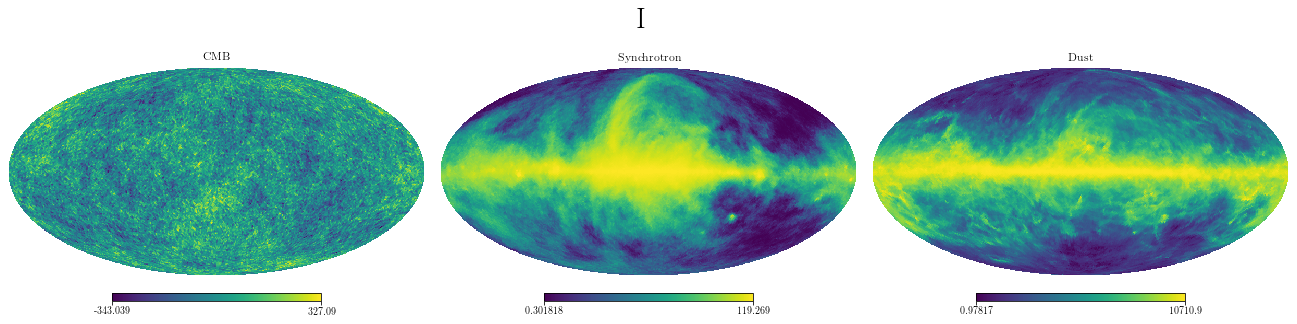

In [36]:
## Intensity templates for CMB, Dust, Synch
fig_temp = plt.figure(figsize=(18, 4.5), num=1)
fig_temp.suptitle('I', fontsize=30)
hp.mollview(CMB_maps[0,0], sub=(1, 3, 1), fig=1, title='CMB')
hp.mollview(synch_maps[6,0], sub=(1, 3, 2), fig=1, norm="hist", title='Synchrotron')
hp.mollview(dust_maps[6,0], sub=(1, 3, 3), fig=1, norm="hist", title='Dust')
plt.show()

## Polarization templates (Q and U) for CMB, Dust, Synch
fig_Q = plt.figure(figsize=(18, 4.5), num=2)
fig_Q.suptitle('Q', fontsize=30)
hp.mollview(CMB_maps[0,1], sub=(1, 3, 1), fig=2, title='CMB')
hp.mollview(synch_maps[6,1], sub=(1, 3, 2), fig=2, norm="hist", title='Synchrotron')
hp.mollview(dust_maps[6,1], sub=(1, 3, 3), fig=2, norm="hist", title='Dust')
plt.show()

fig_U = plt.figure(figsize=(18, 4.5), num=3)
fig_U.suptitle('U', fontsize=30)
hp.mollview(CMB_maps[0,2], sub=(1, 3, 1), fig=3, title='CMB')
hp.mollview(synch_maps[6,2], sub=(1, 3, 2), fig=3, norm="hist", title='Synchrotron')
hp.mollview(dust_maps[6,2], sub=(1, 3, 3), fig=3, norm="hist", title='Dust')
plt.show()

### Set up component separation parameters

Illustrate the SED models in the mixing matrix

In [37]:
# Define the mixing matrix structure
mixing_mat_all_free = MixingMatrix(CMB(), Dust(nu0=100.), Synchrotron(nu0=100.)) # Here: CMB column, Dust column normalized at 100GHz with free beta and T, Synch column normalized at 100 GHz with free beta
print(mixing_mat_all_free.params)
mixing_eval_all_free = mixing_mat_all_free.eval(instrument.frequency, 1.54, 20.0, -3.0) # evaluate at some value of the parameters

mixing_mat_fixed_Td = MixingMatrix(CMB(), Dust(nu0=100., temp=20.0), Synchrotron(nu0=100.)) # Here: CMB column, Dust column normalized at 100GHz with free beta and T fixed at 25K, Synch column normalized at 100 GHz with free beta
print(mixing_mat_fixed_Td.params)
mixing_eval_fixed_Td = mixing_mat_fixed_Td.eval(instrument.frequency, 1.3, -2.5) # evaluate at some value of the parameters

fig = plt.figure(figsize=(8, 8))
plt.plot(instrument.frequency, mixing_eval_all_free[:,0], label="CMB")
plt.plot(instrument.frequency, mixing_eval_all_free[:,2], label="Synch")
plt.plot(instrument.frequency, mixing_eval_all_free[:,1], label="Dust")

plt.plot(instrument.frequency, mixing_eval_fixed_Td[:,2], linestyle='--', color='tab:orange')
plt.plot(instrument.frequency, mixing_eval_fixed_Td[:,1], linestyle='--', color='tab:green')

plt.yscale('log')
plt.legend(loc="upper left", prop={'size':25})

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
['Dust.beta_d', 'Synchrotron.beta_pl']


Define comp sep parameters

In [38]:
# Which mixing matrix structure to use -> which parameters to fit
components = [CMB(), Dust(nu0=100.), Synchrotron(nu0=100.)]

# Optimization parameters for the likelihood minimization
tol_ = 1e-18
options = {'disp': False, 'gtol': tol_, 'eps': tol_, 'maxiter': 10000, 'ftol': tol_}
method = 'TNC' # Truncated Newtonian, others are possible but in our experience this gives the best performance

### Run the component separation

Homogeneous sky and simple component separation so use `basic_comp_sep`

In [39]:
# Run comp sep and store results
result = basic_comp_sep(components, instrument, freq_maps, method=method, tol=tol_, options=options)
print("Success ?", bool(result.status))
print("Best fit parameters: ", result.x)
print("Sigma of the parameters:", np.sqrt(np.diag(result.Sigma)))

Success ? True
Best fit parameters:  [ 1.54000271 19.99995738 -3.00112685]
Sigma of the parameters: [4.58949553e-05 1.54658659e-03 8.26014830e-04]


In [40]:
result.keys()
result.s.shape

(3, 3, 49152)

### Exploit results

Output reconstructed component maps

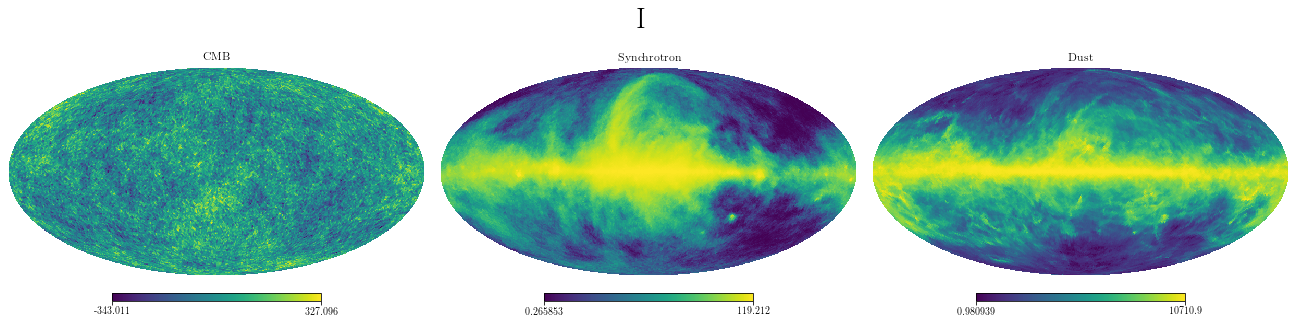

In [41]:
## Reconstructed CMB, Dust, Synch maps
rec_CMB_maps = result.s[0]
rec_synch_maps = result.s[2]
rec_dust_maps = result.s[1]

fig_temp = plt.figure(figsize=(18, 4.5), num=1)
fig_temp.suptitle('I', fontsize=30)
hp.mollview(rec_CMB_maps[0], sub=(1, 3, 1), fig=1, title='CMB')
hp.mollview(rec_synch_maps[0], sub=(1, 3, 2), fig=1, norm="hist", title='Synchrotron')
hp.mollview(rec_dust_maps[0], sub=(1, 3, 3), fig=1, norm="hist", title='Dust')
plt.show()

## Polarization templates (Q and U) for CMB, Dust, Synch
fig_Q = plt.figure(figsize=(18, 4.5), num=2)
fig_Q.suptitle('Q', fontsize=30)
hp.mollview(rec_CMB_maps[1], sub=(1, 3, 1), fig=2, title='CMB')
hp.mollview(rec_synch_maps[1], sub=(1, 3, 2), fig=2, norm="hist", title='Synchrotron')
hp.mollview(rec_dust_maps[1], sub=(1, 3, 3), fig=2, norm="hist", title='Dust')
plt.show()

fig_U = plt.figure(figsize=(18, 4.5), num=3)
fig_U.suptitle('U', fontsize=30)
hp.mollview(rec_CMB_maps[2], sub=(1, 3, 1), fig=3, title='CMB')
hp.mollview(rec_synch_maps[2], sub=(1, 3, 2), fig=3, norm="hist", title='Synchrotron')
hp.mollview(rec_dust_maps[2], sub=(1, 3, 3), fig=3, norm="hist", title='Dust')
plt.show()

Residual maps (relatively to the input maps)

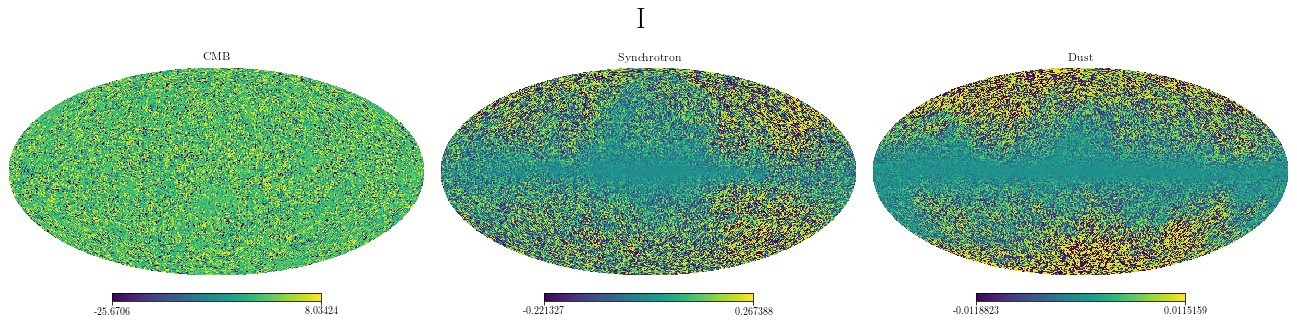

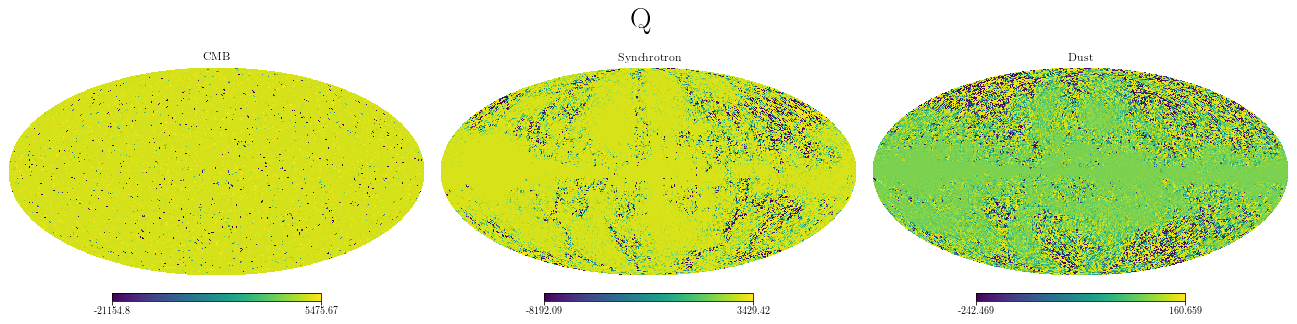

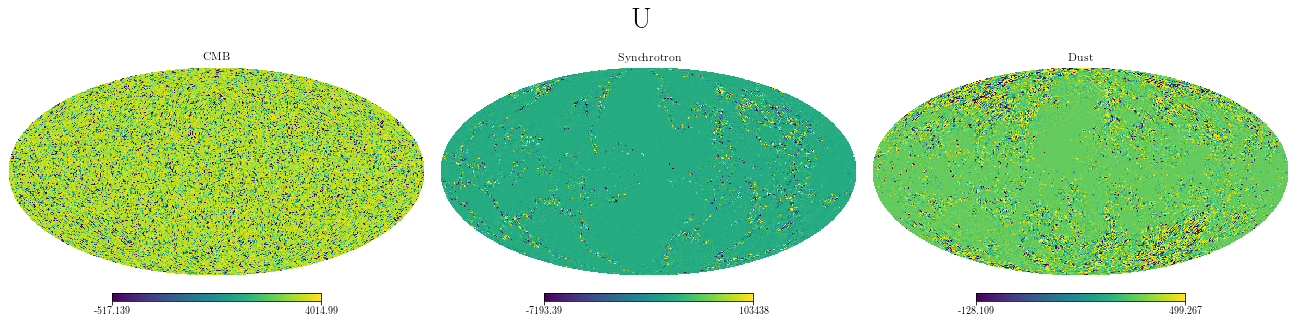

In [45]:
## Reconstructed CMB, Dust, Synch maps
res_CMB_maps = rec_CMB_maps - CMB_maps[6]
res_synch_maps = rec_synch_maps - synch_maps[6]
res_dust_maps = rec_dust_maps - dust_maps[6]

fig_temp = plt.figure(figsize=(18, 4.5), num=1)
fig_temp.suptitle('I', fontsize=30)
hp.mollview(res_CMB_maps[0]/CMB_maps[6,0], sub=(1, 3, 1), fig=1, title='CMB', norm="hist")
hp.mollview(res_synch_maps[0]/synch_maps[6,0], sub=(1, 3, 2), fig=1, norm="hist", title='Synchrotron')
hp.mollview(res_dust_maps[0]/dust_maps[6,0], sub=(1, 3, 3), fig=1, norm="hist", title='Dust')
plt.show()

## Polarization templates (Q and U) for CMB, Dust, Synch
fig_Q = plt.figure(figsize=(18, 4.5), num=2)
fig_Q.suptitle('Q', fontsize=30)
hp.mollview(res_CMB_maps[1]/CMB_maps[6,1], sub=(1, 3, 1), fig=2, title='CMB', norm="hist")
hp.mollview(res_synch_maps[1]/synch_maps[6,1], sub=(1, 3, 2), fig=2, norm="hist", title='Synchrotron')
hp.mollview(res_dust_maps[1]/dust_maps[6,1], sub=(1, 3, 3), fig=2, norm="hist", title='Dust')
plt.show()

fig_U = plt.figure(figsize=(18, 4.5), num=3)
fig_U.suptitle('U', fontsize=30)
hp.mollview(res_CMB_maps[2]/CMB_maps[6,2], sub=(1, 3, 1), fig=3, title='CMB', norm="hist")
hp.mollview(res_synch_maps[2]/synch_maps[6,2], sub=(1, 3, 2), fig=3, norm="hist", title='Synchrotron')
hp.mollview(res_dust_maps[2]/dust_maps[6,2], sub=(1, 3, 3), fig=3, norm="hist", title='Dust')
plt.show()

Produce residual power-spectra

In [43]:
Cl_res = hp.anafast(res_CMB_maps)[2, 2:2*nside]
Cl_res.shape

(126,)

Plot B-mode residuals and compare with CMB B modes

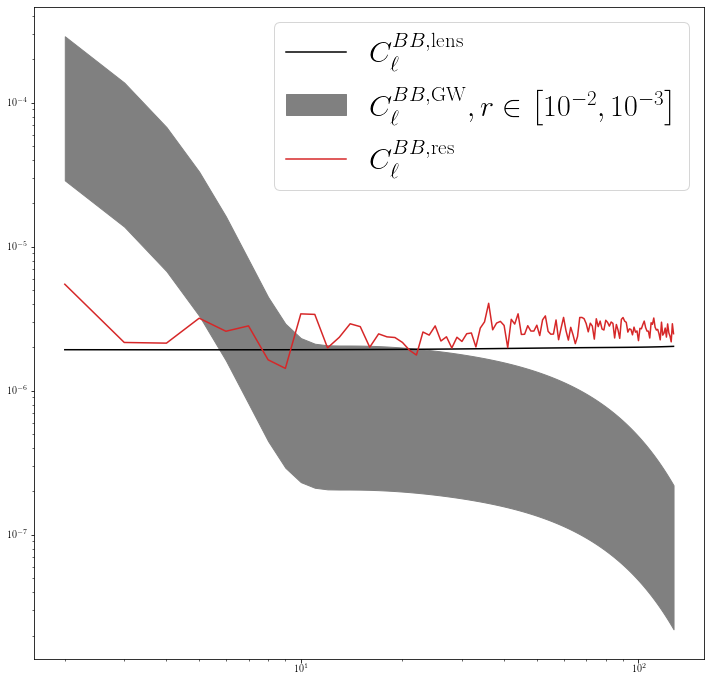

In [46]:
ell = np.arange(2, 2*nside)
Cl_lens = hp.read_cl("/home/cleloup/software/fgb_tutorials/templates/Cls_Planck2018_lensed_scalar.fits")[2, 2:2*nside] #only take B modes
Cl_prim = hp.read_cl("/home/cleloup/software/fgb_tutorials/templates/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")[2, 2:2*nside] #only take B modes

fig = plt.figure(figsize=(12, 12))
plt.xscale('log')
plt.yscale('log')
plt.plot(ell, Cl_lens, color='k', label=r'$C_{\ell}^{BB, {\rm lens}}$')
plt.fill_between(ell, 0.001*Cl_prim, 0.01*Cl_prim, color='gray', label=r'$C_{\ell}^{BB, {\rm GW}}, r \in \left[ 10^{-2}, 10^{-3} \right] $')
plt.plot(ell, Cl_res, color='tab:red', label=r'$C_{\ell}^{BB, {\rm res}}$')
plt.legend(loc="upper right", prop={'size':30})

## xForecast

xForecast is part of FGBuster, but philosophy behind is different so we define a new section

In [47]:
from fgbuster.cosmology import xForecast

Define inputs for xForecast, similar to FGBuster with some important differences

In [48]:
components_xF = [CMB(), Dust(nu0=100.), Synchrotron(nu0=100.)]

instrument_xF = get_instrument('LiteBIRD')
instrument_xF = standardize_instrument(instrument_xF)

nside = 64 #simulated sky nside
synch_model_xF, dust_model_xF = "s0", "d0"

# Input maps for xForecast are NOISELESS, FOREGROUNDS ONLY maps
synch_maps_xF = get_observation(instrument_xF, synch_model_xF, nside=nside)
dust_maps_xF = get_observation(instrument_xF, dust_model_xF, nside=nside)

# Coadd maps
freq_maps_xF = synch_maps_xF + dust_maps_xF 

Run xForecast, plotting predefined figures

fsky =  1.0
======= ESTIMATION OF SPECTRAL PARAMETERS =======
res.x =  [ 1.53999987 20.         -3.        ]
======= ESTIMATION OF NOISE AFTER COMP SEP =======
======= COMPUTATION OF CL_FGS =======
======= ESTIMATION OF STAT AND SYS RESIDUALS =======
======= OPTIMIZATION OF COSMO LIKELIHOOD =======
bounds on r =  0.0  /  1.0233402121916423e-05
starting point =  1e-05
    ===>> fitted r =  [1.e-05]
======= ESTIMATION OF SIGMA(R) =======
ind_sr_min =  4
sr_grid[ind_sr_min-1] =  [4.21696503e-05]
sr_grid[ind_sr_min+1] =  [0.00011007]
sr_grid =  [[1.00000000e-05]
 [1.61559810e-05]
 [2.61015722e-05]
 [4.21696503e-05]
 [6.81292069e-05]
 [1.10069417e-04]
 [1.77827941e-04]
 [2.87298483e-04]
 [4.64158883e-04]
 [7.49894209e-04]
 [1.21152766e-03]
 [1.95734178e-03]
 [3.16227766e-03]
 [5.10896977e-03]
 [8.25404185e-03]
 [1.33352143e-02]
 [2.15443469e-02]
 [3.48070059e-02]
 [5.62341325e-02]
 [9.08517576e-02]
 [1.46779927e-01]
 [2.37137371e-01]
 [3.83118685e-01]
 [6.18965819e-01]
 [1.00000000e+00]]
ca

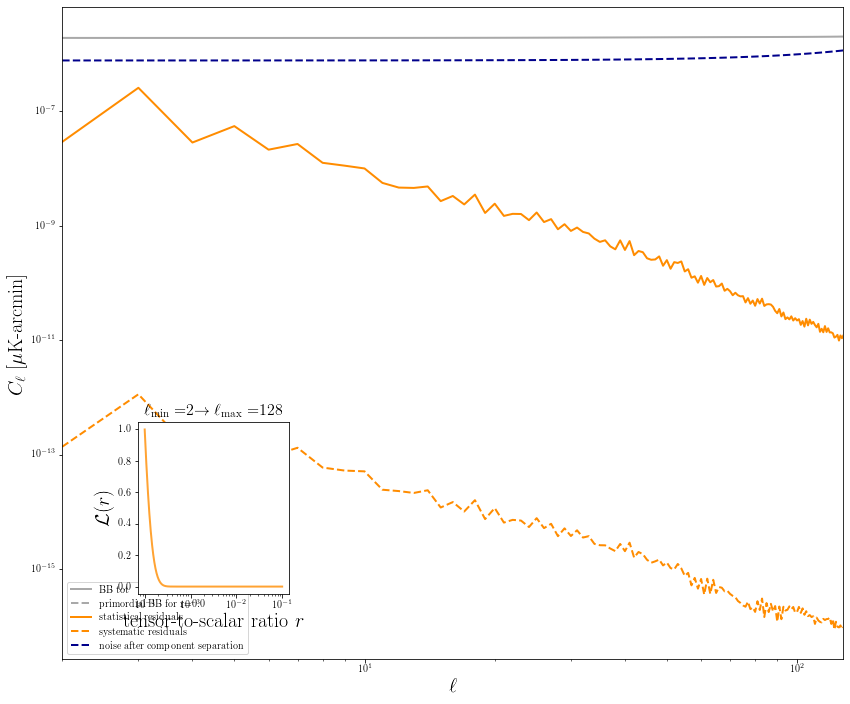

In [50]:
result_xF = xForecast(components_xF, instrument_xF, freq_maps_xF, lmin=2, lmax=2*nside, r=0.0, make_figure=True)